# Artistic Style Transfer (using VGG19)

In [0]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/Team Drives/Deep Learning/Final Project/'
myDrive = '/content/drive/Team Drives/Deep Learning/Final Project/'

In [0]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications import VGG19
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Loading the content and style images

Size:  [512, 512] 



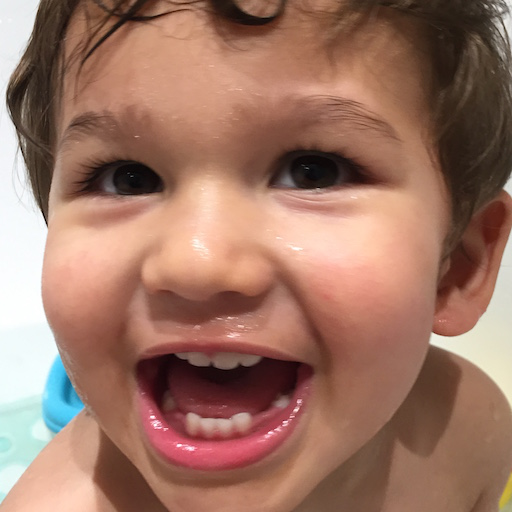

In [0]:
content_image_path = myDrive + 'images/hugo.jpg'
content_image = Image.open(content_image_path)
width, height = content_image.size

while width > 750: 
  width = int(width*0.5)
  height = int(height*0.5)
  
print("Size: ", [width,height], "\n")

content_image = content_image.resize((width, height))
content_image

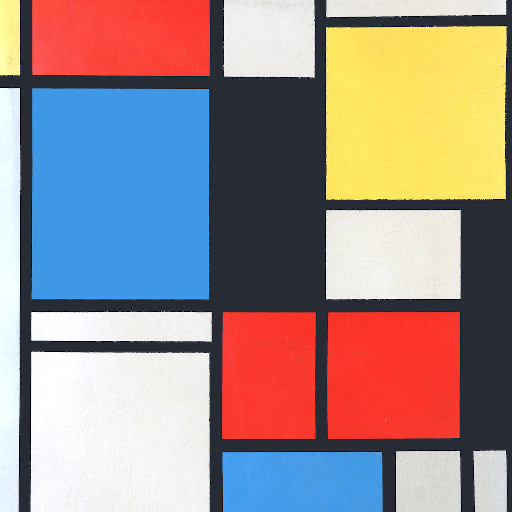

In [0]:
style_image_path = myDrive + 'images/styles/block.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [0]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(height, width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img
  


def deprocess_image(x):
    x = x.reshape((height, width, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# We convert the images into a numerical processing suitable form

content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
# We adapt the input data to match the VGG Network we are going to use

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [0]:
# We create the the tensor wit all the image data concatenated

content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [0]:
# Now we can use the VGG19 model with the tensor we have generated

model = VGG19(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [0]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

# We print the layers
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_5/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_5/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_5/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_5/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_5/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_5/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_5/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_5/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_5/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4_5/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_5/MaxPool:0' shape=(3, 64, 64, 

In [0]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

loss = backend.variable(0.)

In [0]:
# We define the CONTENT LOSS function

def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block5_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + content_weight * content_loss(content_image_features,
                                      combination_features)

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

# We define the STYLE LOSS function
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [0]:
# We define the TOTAL VARIATION LOSS function

def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
# We define the gradients

grads = backend.gradients(loss, combination_image)

In [0]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


# We create an evaluator that computes loss and gradients in one pass  
  
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

# Main Execution

In [0]:
# Now we can apply the artistic style to the image 

x = preprocess_image(content_image_path)

iterations = 10

for i in range(0,iterations):
    print("epoch ",i)
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    img = deprocess_image(x.copy())
    
fname = myDrive + 'hugo_block.png'
save_img(fname, img)

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9


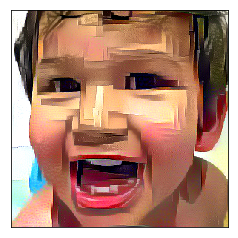

In [0]:
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
plt.show()